In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import *

import json

In [3]:
torch.cuda.set_device(0)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/paperspace/data/Baby_CNN/BCP/Binary')
MASKS_FN = 'CSF.csv'
#Train_FN = 'BCP_training.csv'
#META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
train_csv = [t.replace('label', 'T2') for t in masks_csv['ID']]
train_csv = [t.replace('png', 'jpg') for t in train_csv ]

I=pd.DataFrame(train_csv,columns=['ID'])  
I.to_csv(f'{PATH}/BCP_training.csv')
#meta_csv = pd.read_csv(PATH/META_FN)

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
TRAIN_DN = 'T2_Training'
MASKS_DN = 'CSF'
sz = 256
bs = 32
nw = 8

In [8]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [9]:
x_names = np.array([Path(TRAIN_DN)/o for o in train_csv])
y_names = np.array([Path(MASKS_DN)/o for o in masks_csv['ID']])

###  Here we try a random 20% training dataset instead of fixed number
### *The code from lesson1-breeds*

In [10]:
n = len(list(open(f'{PATH}/BCP_training.csv'))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [11]:
#val_idxs = list(range(200)) ### here we try a random 20% training dataset instead of fixed number 
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)


Fastai provides an easy and effective way to augment your data. Its data augmentation capabilities are stored within [transform.py] (https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1) in the fastai library.

In [12]:
trn_x.shape,val_x.shape

((788,), (196,))

####  data augmentation parameters experiments 

In [13]:
aug_tfms = [RandomRotate(4,p=0.7, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [14]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [15]:
md.trn_ds.fnames[0]

PosixPath('T2_Training/subject-1-T2_slice_0088.jpg')

In [16]:
md.trn_y

array([PosixPath('CSF/subject-1-label_slice_0088.png'), PosixPath('CSF/subject-1-label_slice_0089.png'),
       PosixPath('CSF/subject-1-label_slice_0090.png'), PosixPath('CSF/subject-1-label_slice_0091.png'),
       PosixPath('CSF/subject-1-label_slice_0092.png'), PosixPath('CSF/subject-1-label_slice_0093.png'),
       PosixPath('CSF/subject-1-label_slice_0094.png'), PosixPath('CSF/subject-1-label_slice_0095.png'),
       PosixPath('CSF/subject-1-label_slice_0096.png'), PosixPath('CSF/subject-1-label_slice_0097.png'),
       PosixPath('CSF/subject-1-label_slice_0098.png'), PosixPath('CSF/subject-1-label_slice_0099.png'),
       PosixPath('CSF/subject-1-label_slice_0100.png'), PosixPath('CSF/subject-1-label_slice_0101.png'),
       PosixPath('CSF/subject-1-label_slice_0102.png'), PosixPath('CSF/subject-1-label_slice_0103.png'),
       PosixPath('CSF/subject-1-label_slice_0104.png'), PosixPath('CSF/subject-1-label_slice_0105.png'),
       PosixPath('CSF/subject-1-label_slice_0106.png'),

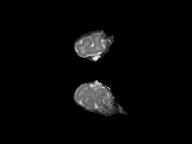

In [17]:
fn = f'{PATH}/{md.trn_ds.fnames[90]}'; fn
img = PIL.Image.open(fn); img

In [18]:
x,y = next(iter(md.trn_dl))

In [19]:
x.shape,y.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

## Simple upsample

## simple use

In [20]:
f = resnet34
cut,lr_cut = model_meta[f]

In [21]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [22]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [23]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [24]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [25]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

####  Since our image is very different from the fastai course, we need to change the learning rate across layers.  
####  we should let the first layers learning rate faster to make it learn quicker. 

## U-net (ish)

In [26]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [27]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [28]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [29]:
# 

In [30]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [31]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [32]:
# m_base = get_base()
# m = to_gpu(DynamicUnet(m_base))
# models = UnetModel(m)

In [33]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [34]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 64, 

In [35]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 128, 128]),
 torch.Size([3, 64, 64, 64]),
 torch.Size([3, 128, 32, 32]),
 torch.Size([3, 256, 16, 16])]

In [36]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 96%|█████████▌| 24/25 [00:14<00:00,  1.67it/s, loss=2.24] 

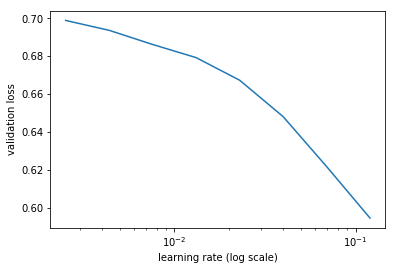

In [37]:
learn.lr_find()
learn.sched.plot()

In [38]:
lr=1e-1
wd=1e-2

#lrs = np.array([lr/100,lr/10,lr])/2

### Use the new way of doing things with restart (recommended):

In [39]:
learn.fit(lr, n_cycle=3, wds=0.025, use_wd_sched=True, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

 72%|███████▏  | 18/25 [00:09<00:03,  1.80it/s, loss=0.299]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.234421   4.361813   0.659019   0.246081  
    1      0.138506   0.075442   0.965662   0.715254       
    2      0.108008   0.103113   0.953304   0.511097       
    3      0.093463   0.0658     0.974207   0.797223        
    4      0.08142    0.063124   0.97453    0.801732        
    5      0.073712   0.061008   0.974189   0.799196        
    6      0.071345   0.07482    0.97354    0.787759        
    7      0.068216   0.061822   0.972523   0.784335        
    8      0.064663   0.058034   0.974585   0.80333         
    9      0.062453   0.058541   0.977202   0.818872        
    10     0.060861   0.064755   0.976737   0.811847        
    11     0.059297   0.057181   0.978008   0.824539        
    12     0.057625   0.053321   0.976919   0.821623        
    13     0.056134   0.052943   0.977304   0.82404         



[array([ 0.05294]), 0.97730356333207113, 0.82404024958933175]

#### Differential learning rate and weight regularization factor (wds):

In [40]:

learn.unfreeze()
learn.fit(lrs=[lr/100, lr/10,lr], n_cycle=5, wds=[wd/100, wd/10, wd], use_wd_sched=True, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=62), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.100173   0.068549   0.970612   0.764091  
    1      0.07775    0.059997   0.97468    0.802729        
    2      0.071257   0.058537   0.973208   0.788634        
    3      0.063717   0.052547   0.976577   0.818883        
    4      0.058731   0.049943   0.979162   0.836514        
    5      0.055507   0.049363   0.979038   0.836977        
    6      0.054264   0.049538   0.978413   0.83266         
    7      0.05304    0.059526   0.972339   0.779508        
    8      0.051754   0.047735   0.978976   0.837886        
    9      0.050456   0.045788   0.981217   0.851902        
    10     0.049166   0.049282   0.981372   0.848604        
    11     0.047787   0.043952   0.981896   0.857685        
    12     0.046389   0.043502   0.981818   0.85812         
    13     0.045388   0.043384   0.981694   0.857752        
    14     0.046213   0.049463   0.980696   0.845954        
    15     0.046984   0.046446 

[array([ 0.03083]), 0.98765844228316324, 0.90454141693591306]

In [41]:
learn.save('256urn-csf')

In [42]:
learn.load('256urn-csf')
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

0.9134793337446021
0.9061701350857977
0.8945696800681695
0.9055163199083794
0.9189697954992727
0.9120845614391706
0.9018262723648837
0.8989769820971867
0.9061170464214806
0.9188716924613081
0.9014553014553015
0.8911722141823444
0.8817377312952535
0.8810725552050473
0.8865598027127004
0.8852165001281066


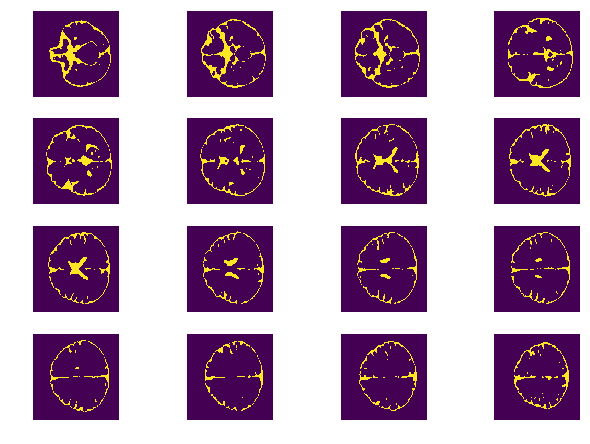

In [43]:
fig,  axes  =  plt.subplots(4, 4, figsize=(9, 6))

for i,ax in enumerate(axes.flat):

    pred=py[i]>0
    targs=y[i]
    show_img(pred, ax=ax)
    plt.tight_layout(pad=0.1)
#     show_img(pred);
#     show_img(targs);
#     plt.hist(targs)
#     plt.show()

    print(2. * (pred*targs).sum() / (pred+targs).sum())

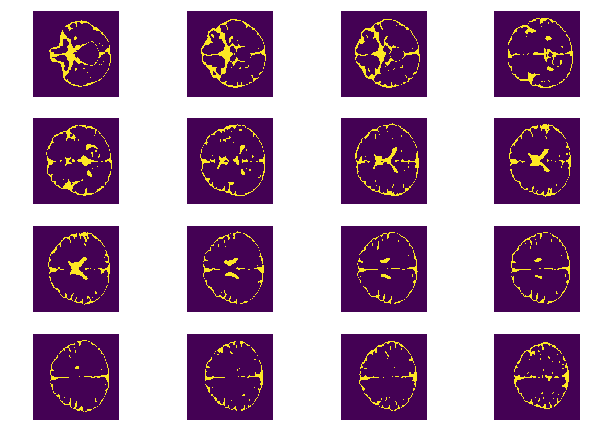

In [44]:
fig,  axes  =  plt.subplots(4, 4, figsize=(9, 6))

for i,ax in enumerate(axes.flat):

    pred=py[i]>0
    targs=y[i]
    show_img(targs, ax=ax)
    plt.tight_layout(pad=0.1)

In [ ]:
m.close()